# Predicted ICU cases, by region

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as th
import pandas as pd
import numpy as np
from git_root import git_root
import matplotlib.pylab as plt
import sys
import os
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.models import EpidemicModel, PoissonLogLikelihood
from src.utils import train_model_region, predict_vs_actual_by_region, plot_pred_vs_act_multistep, plot_pred_vs_act_one_step


In [3]:
from src.utils import train_model

In [4]:
scale_by = 100

## Load and prepare data

In [5]:
df = pd.read_csv(os.path.join(git_root(), "data", "df_it.csv"))

In [6]:
df[["date", "region_name", "cases_pos_new", "cases_pos_total", "cases_pos_hospitalized_icu"]].head()

,date,region_name,cases_pos_new,cases_pos_total,cases_pos_hospitalized_icu
0,2020-02-24 18:00:00,Abruzzo,0,0,0
1,2020-02-24 18:00:00,Veneto,32,32,4
2,2020-02-24 18:00:00,Valle d'Aosta,0,0,0
3,2020-02-24 18:00:00,Umbria,0,0,0
4,2020-02-24 18:00:00,P.A. Trento,0,0,0


In [7]:
df["cases_pos_hospitalized_icu_change"] = df.groupby("region_name").cases_pos_hospitalized_icu.diff()
df["cases_pos_hospitalized_icu_change"] = np.where(df["cases_pos_hospitalized_icu_change"] < 0, 0, df["cases_pos_hospitalized_icu_change"])
df = df.dropna()

## By region

In [8]:
test_regions = ['Abruzzo', 'Piemonte', 'Veneto']
df_train = df.loc[~df['region_name'].isin(test_regions)]
df_test = df.loc[df['region_name'].isin(test_regions)]

In [9]:
model_region = train_model_region(df_train, scale_by=scale_by, seed=2, max_grad=10, learning_rate=1e-3, 
                                  n_epochs=1000, print_every=100, which_model="unit_root")

epoch = 0, train error = 2.72827
epoch = 100, train error = 0.82328
epoch = 200, train error = 0.80443
epoch = 300, train error = 0.79794
epoch = 400, train error = 0.79483
epoch = 500, train error = 0.79310
epoch = 600, train error = 0.79208
epoch = 700, train error = 0.79145
epoch = 800, train error = 0.79105
epoch = 900, train error = 0.79080


In [10]:
df_pred_act = predict_vs_actual_by_region(df, model_region, scale_by=scale_by)

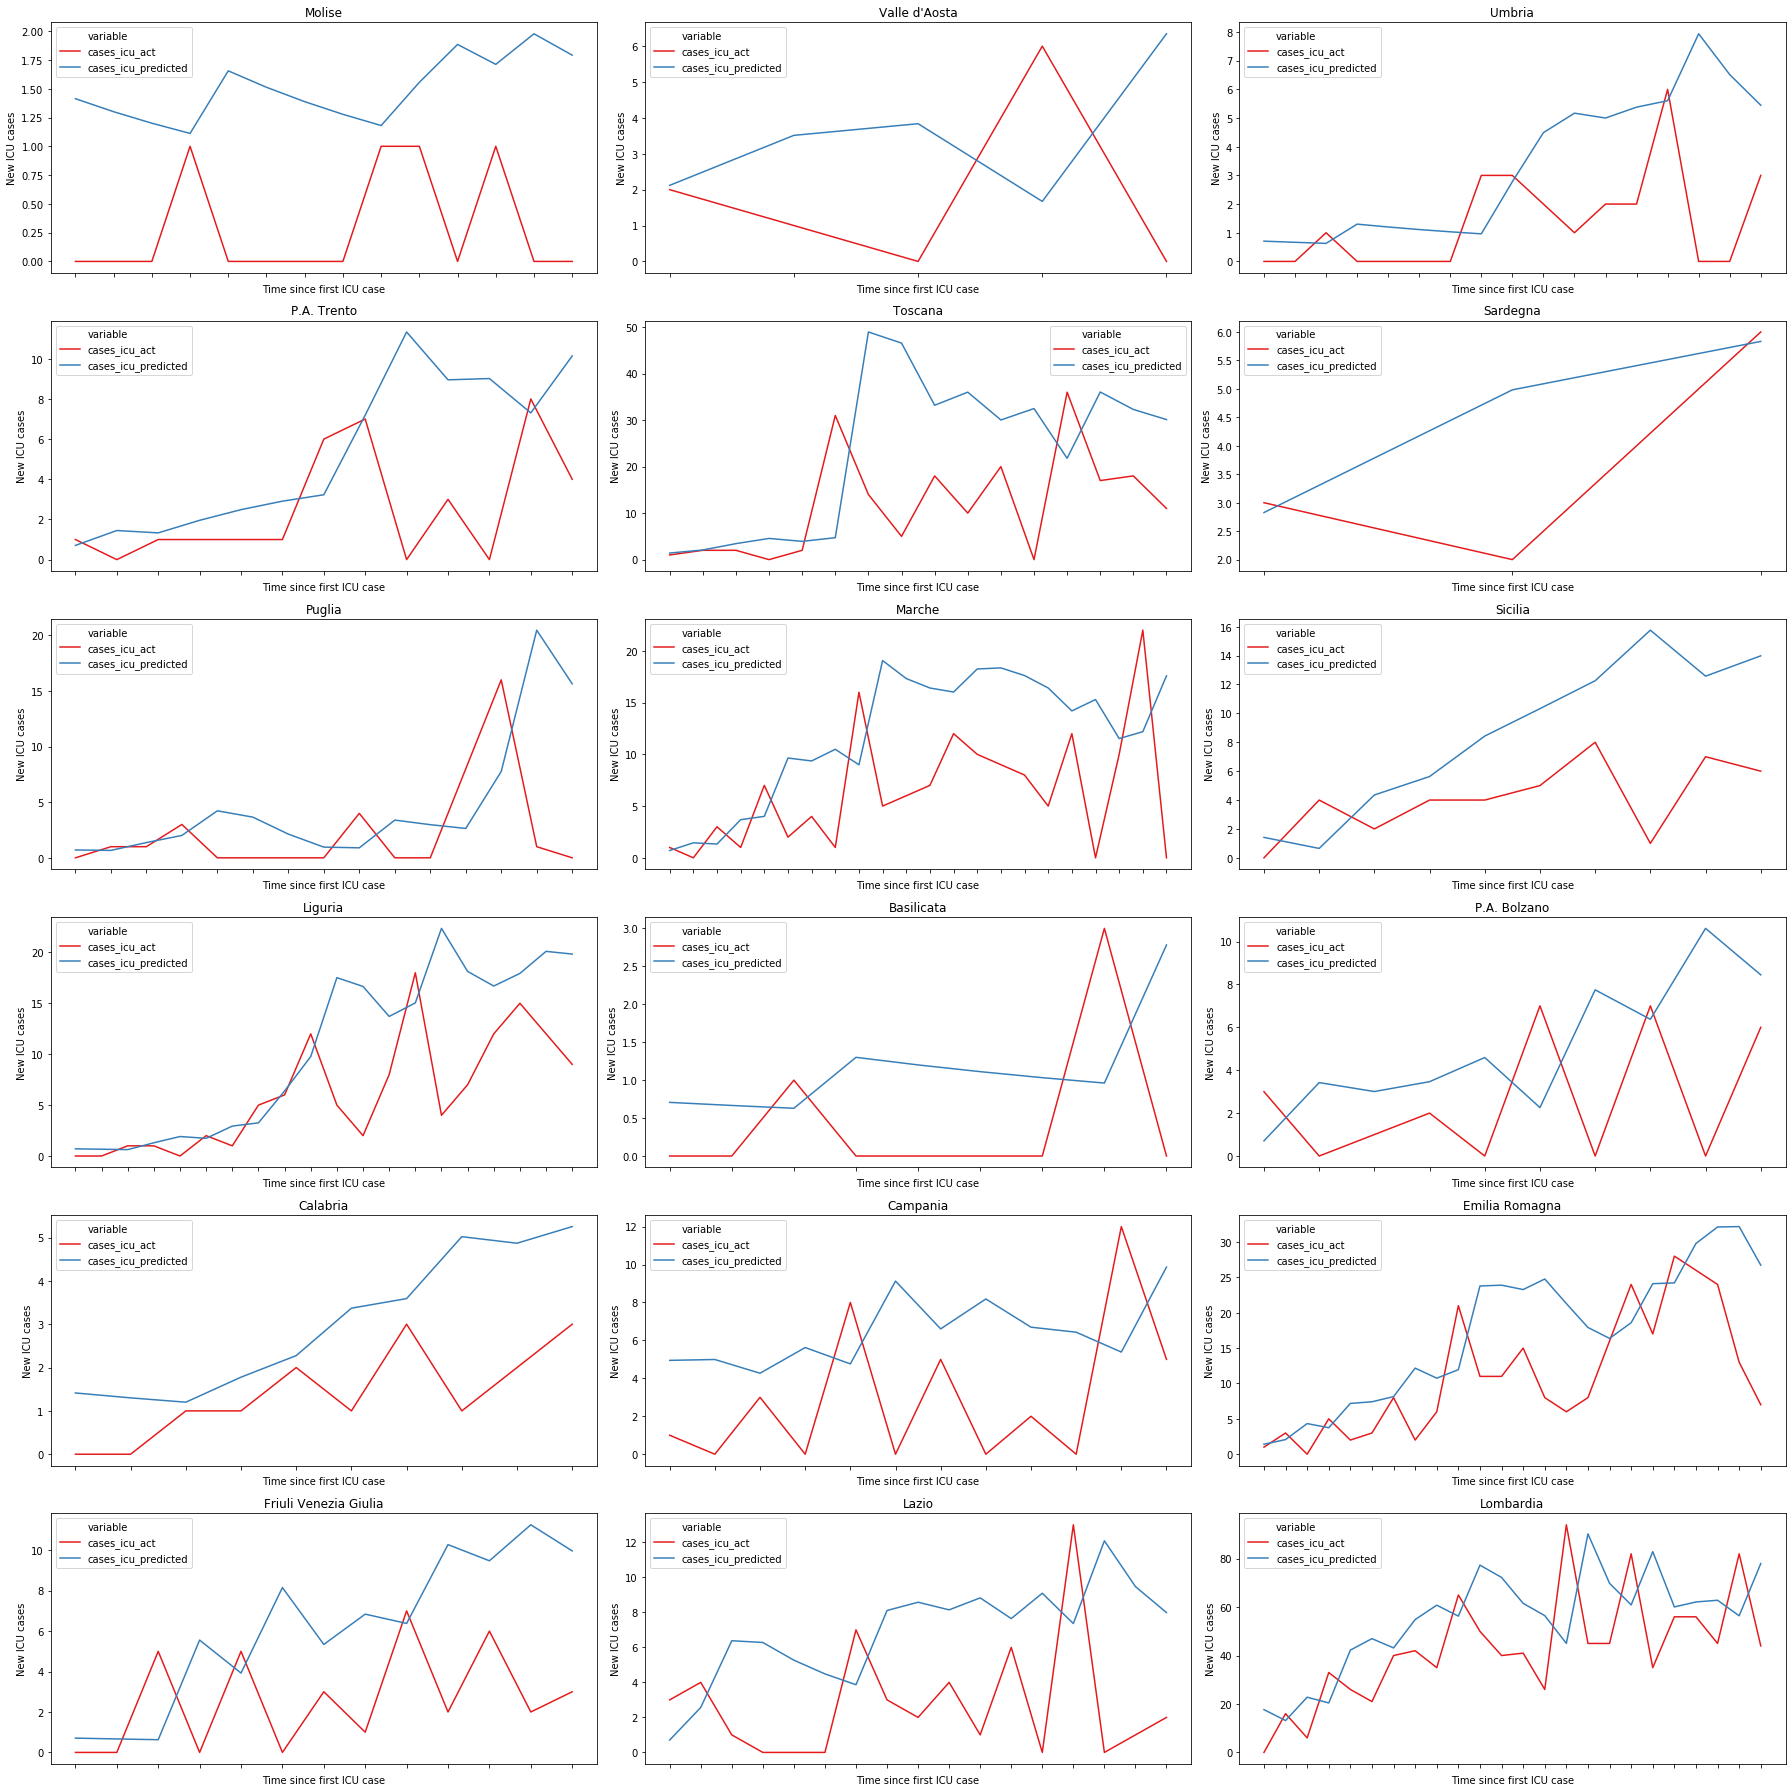

In [13]:
fig, ax = plt.subplots(6, 3, figsize=(25, 25))
cnt = 0
for region in df_pred_act['region_name'].unique():
    if region in df_train['region_name'].unique():
        df_pred = df_pred_act[['date', 'cases_icu_act', 'cases_icu_predicted']].loc[df_pred_act['region_name'] == region]
        df_pred = pd.melt(df_pred, id_vars="date")
        plt.xticks(rotation=45)
        i = cnt // 3
        j = cnt - i * 3
        cnt += 1
        sns.lineplot(ax = ax[i, j], data=df_pred, x="date", y="value", hue="variable", palette=sns.color_palette("Set1", n_colors=2))
        ax[i, j].set_xticklabels('')
        ax[i, j].set_title(region)
        ax[i, j].set_ylabel('New ICU cases')
        ax[i, j].set_xlabel('Time since first ICU case')
fig.tight_layout()
fig.savefig(os.path.join(os.getcwd(), '..', 'output', 'figs', 'in_sample_pred_actual_region.pdf'))

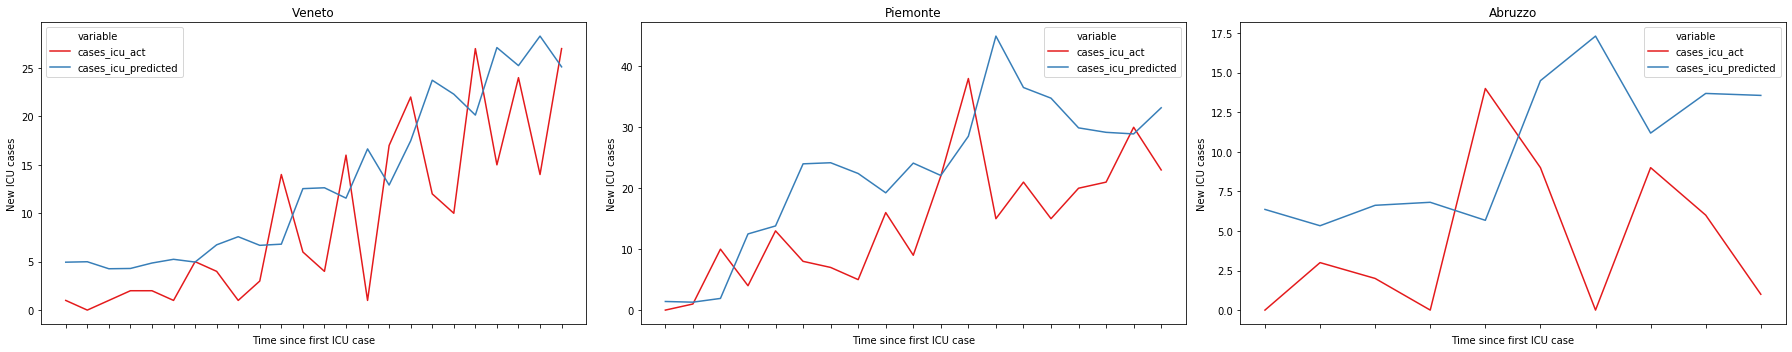

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
cnt = 0
for region in df_pred_act['region_name'].unique():
    if region in df_test['region_name'].unique():
        df_pred = df_pred_act[['date', 'cases_icu_act', 'cases_icu_predicted']].loc[df_pred_act['region_name'] == region]
        df_pred = pd.melt(df_pred, id_vars="date")
        plt.xticks(rotation=45)
        sns.lineplot(ax = ax[cnt], data=df_pred, x="date", y="value", hue="variable", palette=sns.color_palette("Set1", n_colors=2))
        ax[cnt].set_xticklabels('')
        ax[cnt].set_title(region)
        ax[cnt].set_ylabel('New ICU cases')
        ax[cnt].set_xlabel('Time since first ICU case')
        cnt += 1
fig.tight_layout()
fig.savefig(os.path.join(os.getcwd(), '..', 'output', 'figs', 'out_of_sample_pred_actual_region.pdf'))

## Predictions for Veneto

In [15]:
sns.set(font_scale=1.5)
sns.set_style("white")

### One Step Ahead

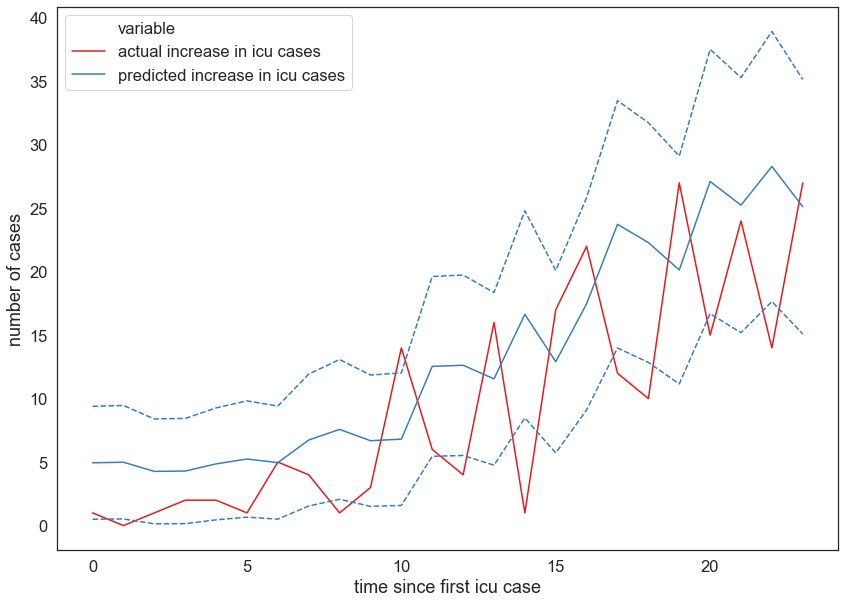

In [19]:
fig, ax = plot_pred_vs_act_one_step(df_pred_act, "Veneto")
fig.savefig(os.path.join(os.getcwd(), '..', 'output', 'figs', 'one_step_ahead_veneto.pdf'))

### Multi-Horizon

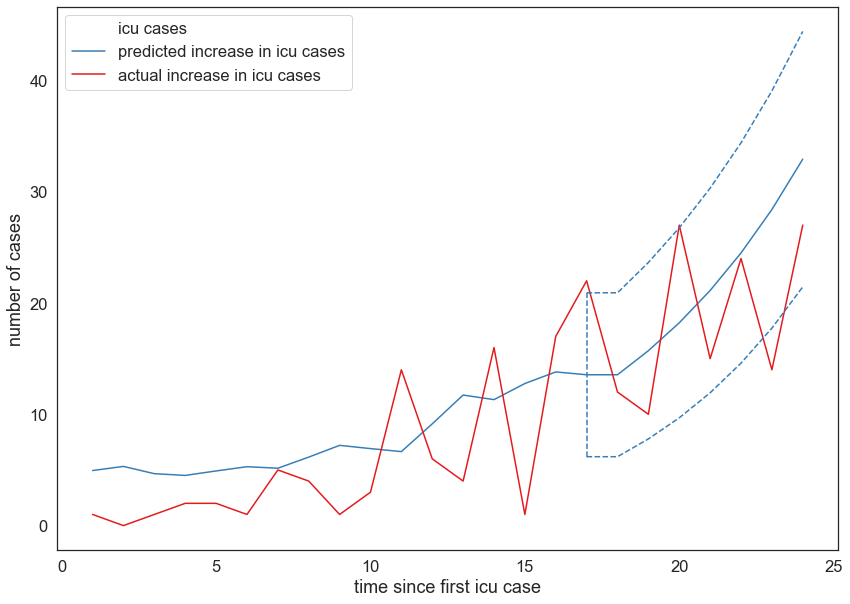

In [18]:
fig, ax = plot_pred_vs_act_multistep(df, model_region, "Veneto", 7, scale_by)
fig.savefig(os.path.join(os.getcwd(), '..', 'output', 'figs', 'multi_step_veneto.pdf'))